In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/CSS/LDS6_K268_ONLINE_HuynhVinhThang/LDS6_HuynhVinhThang_Cuoi_ky'

/content/gdrive/My Drive/CSS/LDS6_K268_ONLINE_HuynhVinhThang/LDS6_HuynhVinhThang_Cuoi_ky


#Cho dữ liệu NIH.csv
#Yêu cầu: Chuẩn hóa dữ liệu (ví dụ: loại bỏ ký tự số, ký tự đặc biệt, stopword,...) và chọn thuật toán thích hợp để thực hiện phân cụm dựa trên cột abstract text.
  1. Áp dụng thuật toán phân cụm thích hợp và cho biết tại sao?
  2. Tìm kết quả => cho biết có bao nhiêu cụm => mẫu nào thuộc cụm nào
  3. Vẽ Wordclouds cho từng cụm (10 keywords lớn nhất). Nhận xét từng cụm.

#Load Library

In [ ]:
import pandas as pd
import numpy as np

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier

#Load DataSet

In [ ]:
df = pd.read_csv('NIH.csv', encoding = 'latin-1')
df.head()

,id,abstract_text
0,8693991,Methamphetamine (MA) is remarkably addictive a...
1,8693362,Project Summary Risk bimarkers have become in...
2,8607498,DESCRIPTION (provided by applicant): Despi...
3,8697008,DESCRIPTION (provided by applicant): This ...
4,8725943,Antigen presenting cells (APCs) are critical f...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             100 non-null    int64 
 1   abstract_text  100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


The data have 100 entries and we just need the abstract column.

## Data Preprocessing

In [ ]:
df_keywords = df[['abstract_text']]
df_keywords.head()

,abstract_text
0,Methamphetamine (MA) is remarkably addictive a...
1,Project Summary Risk bimarkers have become in...
2,DESCRIPTION (provided by applicant): Despi...
3,DESCRIPTION (provided by applicant): This ...
4,Antigen presenting cells (APCs) are critical f...


First we need to set all the character in every single row into lowercase. Because it will be easier for Python to take the same words.

In [ ]:
df_keywords['abstract_text'] = df_keywords['abstract_text'].str.replace('[^a-zA-Z]',' ').str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_keywords['char_count'] = df_keywords['abstract_text'].str.len()
df_keywords['word_count'] = df_keywords['abstract_text'].str.split(' ').str.len()
df_keywords['avg_word_length'] = df_keywords['char_count']/df_keywords['word_count']

In [ ]:
df_keywords.head()

,abstract_text,char_count,word_count,avg_word_length
0,methamphetamine ma is remarkably addictive a...,2723,491,5.545825
1,project summary risk bimarkers have become in...,3042,474,6.417722
2,description provided by applicant despi...,1528,257,5.945525
3,description provided by applicant this ...,4232,726,5.829201
4,antigen presenting cells apcs are critical f...,1857,352,5.275568


- The data showed that almost the text contain more than 100 words, which mean there are alot of words and stopword to handle.
- I will use TfidfVectorizer to transform the data

In [ ]:
tfidf = TfidfVectorizer(max_features=5000,  stop_words='english')  #'''max_features=150,'''

In [1]:
X = tfidf.fit_transform(df_keywords['abstract_text'])
X = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
X.head()

NameError: ignored

After transform, the data's value represent for the inport tance of that word to the text.

In [ ]:
print('Shape of X:', X.shape)

Shape of X: (100, 5000)


In [ ]:
X = X.transpose()
X.shape

(5000, 100)

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
aaas,0.0,0.0,0.000000,0.0,0.0,0.0,0.051749,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
ab,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
abating,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.068474,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
abilities,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.09267,...,0.0,0.031285,0.0,0.0,0.0,0.073376,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
ability,0.0,0.0,0.082852,0.0,0.0,0.0,0.029248,0.0,0.0,0.02587,0.016558,0.013693,0.0,0.0,0.024374,0.0,0.0,0.084332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039123,0.0,0.0,0.0,0.0,0.0,0.02915,0.0,0.0,0.0,0.046324,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.04997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027887,0.0,0.0,0.0,0.030295,0.0,0.027549,0.0,0.0,0.0


## Clustering

In [ ]:
wsses = []  #WSSE of every k
K = range(1,9)
for k in K:
  kmeanModel = KMeans(n_clusters= k)    #number of cluster
  kmeanModel.fit(X)
  wsses.append(kmeanModel.inertia_) 

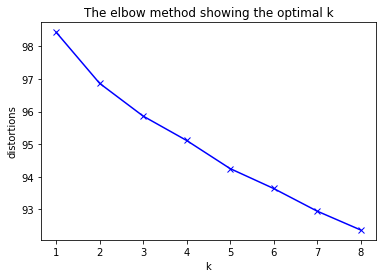

In [ ]:
#Elbow visualization
plt.plot(K, wsses, 'bx-')
plt.xlabel('k')
plt.ylabel('distortions')
plt.title('The elbow method showing the optimal k')
plt.show()

- The plot does not have the elbows clearly, then I will select 3-4 K (cluster).
- In this case, I will select 4.

In [ ]:
model = KMeans(n_clusters=4)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
centroids = model.cluster_centers_
labels = model.labels_               #Cluster label
print('Centriods')
print(centroids)
print(labels)

Centriods
[[ 3.97922580e-03  1.56161694e-02  2.21994891e-03  8.67361738e-19
   6.47571114e-03  6.72682904e-04  1.30104261e-18  4.66106542e-02
   4.02298360e-03  4.60241233e-02  1.21002073e-03  4.09109026e-03
  -2.38524478e-18  2.74372437e-03  5.00279848e-03  3.23333114e-03
   8.85091032e-03  6.08404715e-04  2.03494555e-03  2.00956384e-03
   1.85356066e-03  5.24816677e-04  4.30724135e-03  9.51410034e-03
   1.52036992e-03  3.71239850e-04  2.87210951e-03  6.84450530e-03
   2.06056668e-02  3.39790040e-03  1.44051995e-03  1.01226933e-03
   1.71751431e-03  2.01980608e-03  1.04957162e-02  4.00202838e-03
   8.45235367e-04  1.13472491e-03  6.08741053e-03 -1.73472348e-18
   4.99550525e-03  5.28339311e-03  5.50651810e-03  6.06233752e-02
   1.71371322e-03  4.38495442e-03  3.49379631e-04  9.63688059e-04
   1.30104261e-18  2.72338251e-03  3.00217711e-03  2.60208521e-18
   3.99735573e-03  8.06463222e-04  2.95116200e-03  1.87089267e-02
   1.15139994e-03  2.05572159e-03  4.04102635e-03  5.34248330e-03


In [ ]:
classes = pd.DataFrame(labels)

In [ ]:
classes.value_counts()

2    4403
3     344
1     197
0      56
dtype: int64

In [ ]:
X['Group'] = pd.Series(labels).values

In [ ]:
X['Group'].unique()

array([2, 3, 1, 0], dtype=int32)

##Word Cloud

In [ ]:
X['Total_frequency'] =X.iloc[:,:-1].sum(axis = 1)

In [ ]:
X['Occurrence'] = X.iloc[:,:-1].astype(bool).sum(axis = 1)

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Group,Total_frequency,Occurrence
aaas,0.0,0.0,0.000000,0.0,0.0,0.0,0.051749,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2,0.051749,2
ab,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2,0.146091,2
abating,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.068474,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2,0.068474,2
abilities,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.09267,...,0.0,0.0,0.073376,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2,0.197330,4
ability,0.0,0.0,0.082852,0.0,0.0,0.0,0.029248,0.0,0.0,0.02587,0.016558,0.013693,0.0,0.0,0.024374,0.0,0.0,0.084332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039123,0.0,0.0,0.0,0.0,0.0,0.02915,0.0,0.0,0.0,0.046324,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.04997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027887,0.0,0.0,0.0,0.030295,0.0,0.027549,0.0,0.0,0.0,3,0.597949,17


After running the model, I will insert 2 columns in to the dataframe:
  - Total_frequency: the total value of value in every row, whichs showed for the total important to all text. (It seem not neccessary but I will try then).
  - Occurrence: times the value appear in text (row). If the value is != 0, then the occurence will be 1, it's loop til the end.

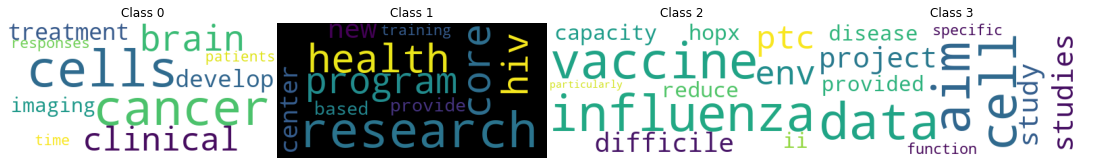

In [ ]:
plt.figure(figsize = (15,15), facecolor = None)
plt.subplot(1,4,1)
Class0 = WordCloud(background_color="white", max_words=50).generate_from_frequencies(X['Total_frequency'][X['Group']==0].sort_values(ascending = False)[:10])
plt.imshow(Class0)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 0')

plt.subplot(1,4,2)
Class1 = WordCloud(background_color="black", max_words=50).generate_from_frequencies(X['Total_frequency'][X['Group']==1].sort_values(ascending = False)[:10])
plt.imshow(Class1)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 1')

plt.subplot(1,4,3)
Class2 = WordCloud(background_color="white", max_words=50).generate_from_frequencies(X['Total_frequency'][X['Group']==2].sort_values(ascending = False)[:10])
plt.imshow(Class2)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 2')

plt.subplot(1,4,4)
Class3 = WordCloud(background_color="white", max_words=50).generate_from_frequencies(X['Total_frequency'][X['Group']==3].sort_values(ascending = False)[:10])
plt.imshow(Class3)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 3')
plt.show()

#####With the Total_frequency value:
- Class0: for those who studying or work on medicine field. 
- Class1: this class for research purpose
- Class2: this class for those who search about some keyword rellevant or will affect their health such as influenza, vaccine.
- Class3: stand for study or other prupose.

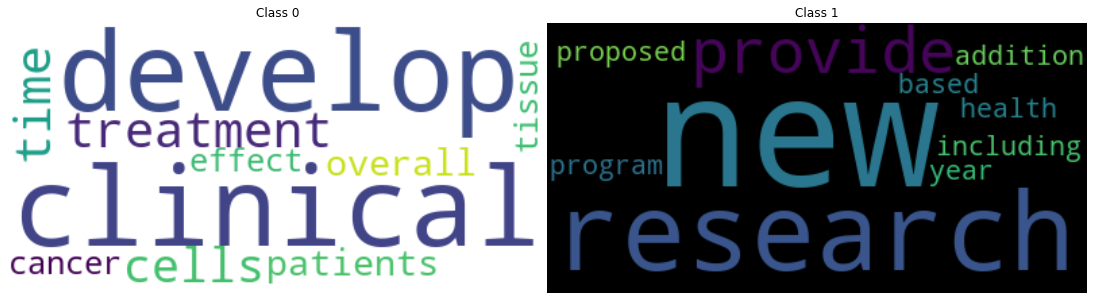

In [ ]:
plt.figure(figsize = (15,15), facecolor = None)
plt.subplot(2,2,1)
Class0 = WordCloud(background_color="white", max_words=10).generate(str(X['Occurrence'][X['Group']==0].sort_values(ascending = False)[:10]))
plt.imshow(Class0, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 0')

plt.subplot(2,2,2)
Class1 = WordCloud(background_color="black", max_words=10).generate(str(X['Occurrence'][X['Group']==1].sort_values(ascending = False)[:10]))
plt.imshow(Class1, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 1')
plt.show()

#####With the Occurrence value:
- Class0: in this class, we can see the keywords not rellevant to medicine field usch as cancer, treatment, patients, etc.
- Class1:  still stand for the researcher while there some rellevant keywords such as research, program

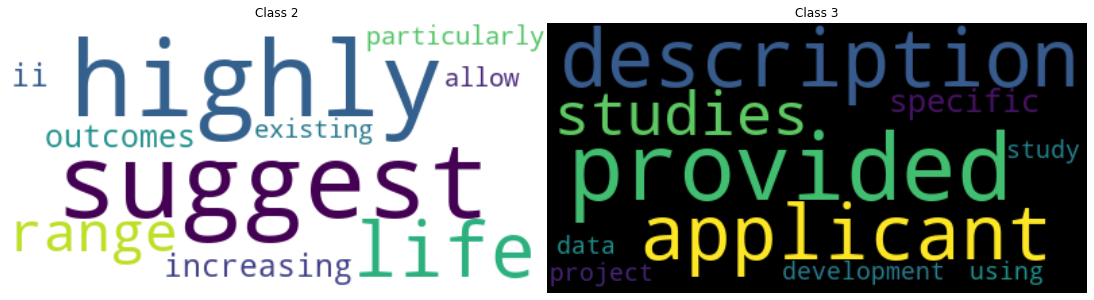

In [ ]:
plt.figure(figsize = (15,15), facecolor = None)

plt.subplot(1,2,1)
Class2 = WordCloud(background_color="white", max_words=10).generate(str(X['Occurrence'][X['Group']==2].sort_values(ascending = False)[:10]))
plt.imshow(Class2, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 2')

plt.subplot(1,2,2)
Class3 = WordCloud(background_color="black", max_words=10).generate(str(X['Occurrence'][X['Group']==3].sort_values(ascending = False)[:10]))
plt.imshow(Class3, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Class 3')
plt.show()

- Class2: stand for some auxiliary keywords.
- Class3: last class stand for studies purpose with some keywords can use in document/ paper 's title.

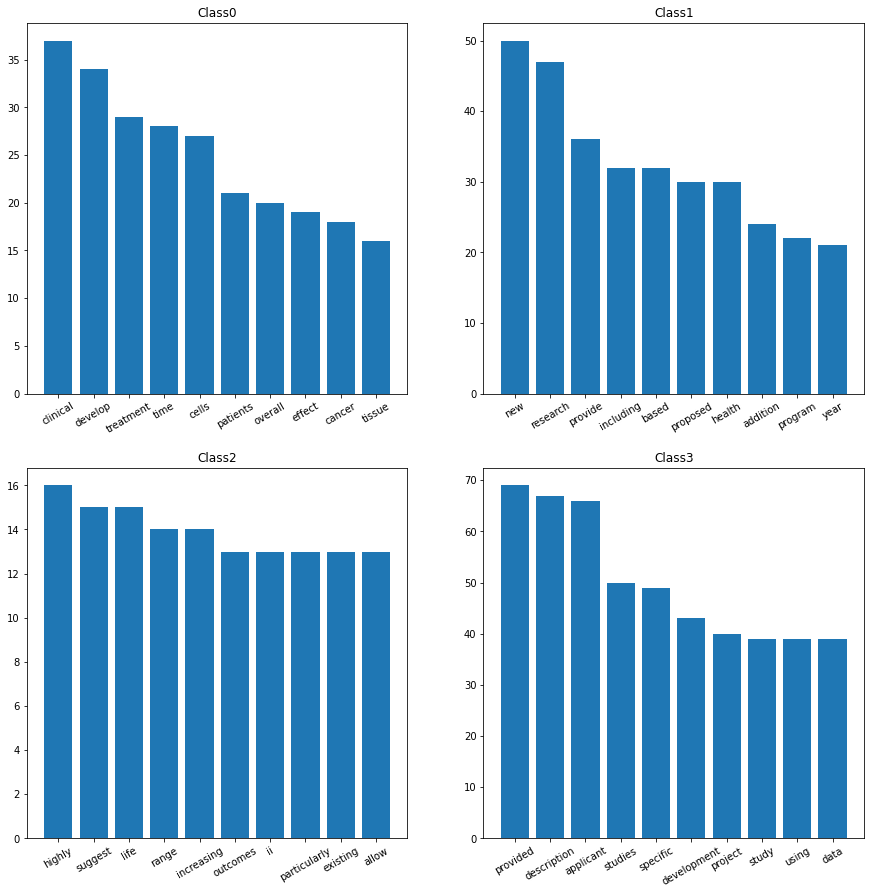

In [ ]:
plt.figure(figsize = (15,15))

plt.subplot(2,2,1)
plt.bar(X['Occurrence'][X['Group']==0].sort_values(ascending = False)[:10].index, X['Occurrence'][X['Group']==0].sort_values(ascending = False)[:10])
plt.title('Class0')
plt.xticks(rotation = 30)

plt.subplot(2,2,2)
plt.bar(X['Occurrence'][X['Group']==1].sort_values(ascending = False)[:10].index, X['Occurrence'][X['Group']==1].sort_values(ascending = False)[:10])
plt.title('Class1')
plt.xticks(rotation = 30)

plt.subplot(2,2,3)
plt.bar(X['Occurrence'][X['Group']==2].sort_values(ascending = False)[:10].index, X['Occurrence'][X['Group']==2].sort_values(ascending = False)[:10])
plt.title('Class2')
plt.xticks(rotation = 30)

plt.subplot(2,2,4)
plt.bar(X['Occurrence'][X['Group']==3].sort_values(ascending = False)[:10].index, X['Occurrence'][X['Group']==3].sort_values(ascending = False)[:10])
plt.title('Class3')
plt.xticks(rotation = 30)
plt.show()

####In conclusion, the model quite good but some issue came up:
    - The elbows not clear so K is not significant.
    - The total_frequent show its stable, when the cluster does not change much after running many times.
    - While the occurrence is unstable and give unrellevant keywords or we can say due to the lack of stopword, I cannot delete all the stopword.
####In this case, I will prefer the frequency value for finding the best keywords that important to the whole text. And the occurence to know the best keyword for every cluster. But not always it show the best result.